In [25]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

# **AA_utils**

In [26]:
def graficar_curva_elbow(X, N, GMM=False):
    plt.figure()
    Nc = range(1, N+1)
    if (GMM):
        kmeans = [GaussianMixture(n_components=i) for i in Nc]
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    if (GMM):
        score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
        scoreBIC = [kmeans[i].fit(X).bic(X) for i in range(len(kmeans))]
    else:
        score = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]

    plt.plot(Nc, score, 'b')
    plt.xlabel('Number of Clusters')
    plt.title('Elbow Curve')
    plt.grid()
    if (GMM):
        plt.ylabel('log(verosimilitud)')
        plt.figure()
        plt.plot(Nc, scoreBIC, 'r--')
        plt.title('BIC Curve')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Bayesian information criterion')
        plt.grid()
    else:
        plt.ylabel('Promedio de sumas de distancias')
    plt.show()


# índice Silhouette
def graficar_indice_silhouette(X, N, GMM=False):

    plt.figure()
    Nc = range(2, N+1)
    if (GMM):
        # kmeans = [GaussianMixture(n_components=i) for i in Nc]
        print("Sin terminar silhouette para GMM")
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    score = [silhouette_score(X, kmeans[i].fit(X).predict(X))
             for i in range(len(kmeans))]
    score
    plt.plot(Nc, score)
    plt.xlabel('Número de Clusters')
    plt.ylabel('Promedio de índice silhouette')
    plt.title('Índice silhouette para distintos K')
    plt.grid()
    plt.show()


def graficar_indice_silhouette_k(X, n_clusters):

    # Compute the silhouette scores for each sample
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    plt.figure()
    ax1 = plt.gca()
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot para cada Cluster.")
    ax1.set_xlabel("Coeficientes silhouette")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()


def graficar_GMM(data, modelo, labels=False, probs=False):
    # display predicted scores by the model as a contour plot
    cant_points = 200
    x = np.linspace(min(data[:, 0])*0.9, max(data[:, 0])*1.1, cant_points)
    y = np.linspace(min(data[:, 1])*0.9, max(data[:, 1])*1.1, cant_points)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    if (probs):
        Z = np.exp(modelo.score_samples(XX))
    else:
        Z = -modelo.score_samples(XX)
    Z = Z.reshape(X.shape)

    centros = modelo.means_
    cant_gauss = centros.shape[0]
    if (probs):
        CS = plt.contour(X, Y, Z, levels=np.linspace(
            0, np.max(Z), cant_gauss*10),  linewidths=2)
        plt.title('Probabilidades de la GMM')
    else:
        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                         levels=np.logspace(0, 3, 20),  linewidths=2)
        plt.title('Negative log-likelihood de la GMM')
    plt.colorbar(CS, shrink=0.5)
    if (labels):
        etiq = modelo.predict(data)
        plt.scatter(data[:, 0], data[:, 1], s=30, c=etiq)
    else:
        plt.scatter(data[:, 0], data[:, 1], s=30)
    plt.scatter(centros[:, 0], centros[:, 1],
                marker='o', c='red', s=100, alpha=0.8)
    plt.grid()
    plt.axis('tight')
    plt.show()


def visualizar_clustering_2D(data, labels, centers):
    values = data.to_numpy()
    plt.figure()
    plt.scatter(values[:, 0], values[:, 1], c=labels, s=50, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1],
                marker='*', c='red', s=600, alpha=0.8)
    plt.show()


def graficar_DBSCAN_2D(data, labels, db, EPS, MINSAM, n_clusters_):
    plt.figure()
    noise_maks = labels == -1
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    # plot RUIDO
    x = data[noise_maks]  # datos RUIDO (outliers)
    plt.scatter(x[:, 0], x[:, 1], color=[0.2, 0.2, 0.2, 0.8],
                s=20, cmap='viridis', label='ruido', marker='x')
    # plot datos CORE en clusters
    x = data[~noise_maks & core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks &
                core_samples_mask], s=30, cmap='viridis', label='Cores')
    # plot datos NO CORE en clusters
    x = data[~noise_maks & ~core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks & ~core_samples_mask],
                s=20, cmap='viridis', label='Borders', marker='D')

    title = "eps= {}, min_samples= {}, #clusters= {}".format(
        EPS, MINSAM, n_clusters_)
    plt.title(title)
    plt.legend()
    plt.show()

# **Calabazas**

**Carga del dataset**

In [27]:
df = pd.read_csv("https://raw.githubusercontent.com/KevinFDI/IML_Practica_4/main/datasets/calabazas.csv") 

**Normalizo**

In [28]:
NORMALIZAR = 1
if (NORMALIZAR):
    scaler = StandardScaler()
    scaler.fit(df)
    df = scaler.transform(df)

**Obtengo el k optimo**

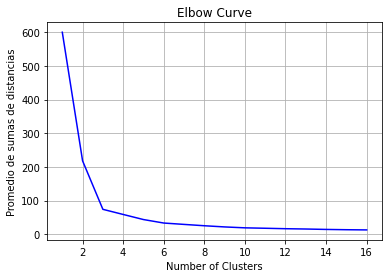

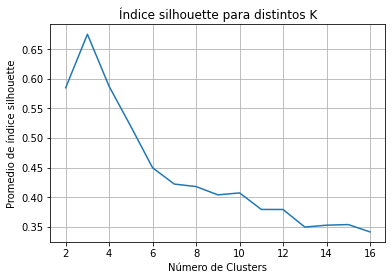

In [29]:
K_MAX = 16
graficar_curva_elbow(df, K_MAX)
graficar_indice_silhouette(df, K_MAX)
k_optimo = 3 # Defino la cantidad de categorías

**Punto Elbow** (punto codo).
*   Grafica el error del modelo para diferentes K.
*   El punto Elbow (si existe) se encuentra en el momento en que el error deja de bajar con la misma intensidad.

**OBSERVACIÓN: Las curvas proponen elegir k = 3**

**Entreno el modelo**

In [30]:
kmeans = KMeans(n_clusters = k_optimo)  # Crea el modelo con K clusters
kmeans.fit(df)                          # Entrena el modelo
# No hay un target, solo le doy los datos del DataFrame para que entrene el modelo.
# El algoritmo sabe que función de error está minimizando (la suma de distancias al cuadrado)

KMeans(n_clusters=3)

K-means es sensible a la escala de los datos
*   Utiliza medida de distancia
*   Es importante normalizar, porque es muy sensible a la escala de los datos (para que las variables se muevan en el mismo rango de valores)
*   El algoritmo K-means (K-medias) es un algoritmo partitivo. 
*   Uno de los más utilizados y más simples de implementar.
*   Dado un conjunto de datos y K centroides: encontrar la posición de los centros que minimicen la suma de distancias.
*   Cada centroide representa un cluster.
*   Minimiza la suma de distancias cuadradas.

**Clasifico cada patrón para los centroides**

In [31]:
labels = kmeans.predict(df)         
# Etiqueta nuevos datos (conjuntos) en un cluster particular

**Centroides**

In [32]:
# Una vez que el algoritmo está entrenando se puede por ejemplo ver cúales son los centros (la cantidad de las categorías serán las definidas en K)
centers = kmeans.cluster_centers_   # Centroides

Análisis del clustering

K = 3 The average silhouette_score is : 0.68


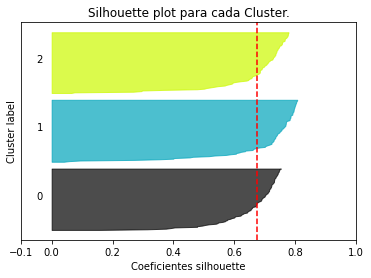

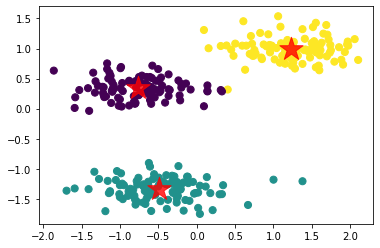

In [33]:
silhouette_avg = silhouette_score(df, labels) # Cuanto más alto mejor
print("K =", k_optimo, "The average silhouette_score is :", round(silhouette_avg, 2))
graficar_indice_silhouette_k(df, k_optimo)
visualizar_clustering_2D(pd.DataFrame(df), labels, centers)

**Índice Silhouette**

Mide cohesión y separación:
*   Cohesión a(x) : distancia promedio de x a todos los elementos en el mismo cluster
*   Separación b(x) : distancia promedio de x a todos los elementos en el cluster más cercano

Índice Silhouette para un punto x:
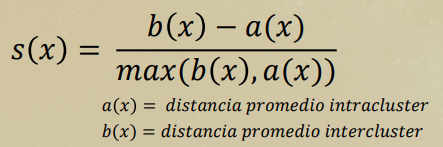


El valor de s(x) varía entre -1 y 1:


*   1 = Buen agrupamiento
*   0 = Indiferente
*   -1 = Mal agrupamiento

**OBSERVACIÓN: En este modelo el índice de Silhouette es de 0.68, por lo que es un buen agrupamiento dado que cuanto mayor sea el número, mejor será el modelo.**

**Método más robusto visto en clase:**

In [34]:
df_norm = df

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_norm = scaler.fit_transform(df_norm)

k = 3

kmeans = KMeans(n_clusters=k).fit(df_norm)

centers = kmeans.cluster_centers_

columnas = pd.DataFrame(df).columns

df_norm = pd.DataFrame(scaler.inverse_transform(centers), columns = columnas)

df_norm.to_excel("calabazas.xlsx")

In [35]:
calabazas = pd.read_excel("/content/calabazas.xlsx") 
round(calabazas.head(),2)

,Unnamed: 0,0,1
0,0,-0.76,0.34
1,1,-0.49,-1.34
2,2,1.24,1.00
